## Calculate the TSN intrinsic value

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
#load data
path_data = '../input/TSN_Q_exp.csv'
data = pd.read_csv(path_data, sep=';', parse_dates=[2])
# filter data
report = 'Q'
# end date years ago
years = 10
# start date 7 year earlier than end date
start_date = pd.Timestamp(datetime.date.today()) - pd.Timedelta(days=(7*365) + (years*365))
end_date = pd.Timestamp(datetime.date.today()) - pd.Timedelta(days=years*365)

data_filt = data.loc[(data['report'] == report) & (data['date'] > start_date) & (data['date'] < end_date), :]
data_filt.reset_index(drop=True, inplace=True)

In [3]:
data_filt.head()

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity,tot_liab,depr_amort,stock_b_comp
0,TSN,Q,2006-10-01,6471,6247,0,235,0,13,-24,...,992,942,912,2846,2987.0,353,4440,6681,134,6.0
1,TSN,Q,2007-01-01,6558,6221,0,190,0,2,145,...,184,1064,770,2018,2777.0,438,4511,5686,128,5.5
2,TSN,Q,2007-04-01,6501,6138,0,205,0,0,158,...,187,960,845,1992,2755.0,435,4577,5617,128,5.5
3,TSN,Q,2007-07-01,6958,6531,0,218,0,0,209,...,150,997,802,1949,2827.0,452,4683,5633,130,5.5
4,TSN,Q,2007-10-01,6883,6577,0,204,0,0,102,...,137,1050,928,2115,2642.0,372,4731,5496,128,5.5


### Calculate EBITDA, EBIT, NOPAT, CAPEX etc on hisorical data

In [4]:
def calculate_missing_columns(df):
    df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm'] - df['r_d'] - df['other_charg']
    df['ebit'] = df['ebitda'] - df['depr_amort']
    df['nopat'] = df['ebit'] - df['inc_tax_exp']
    df['other_curr_ass_lesscash'] = df['acc_rec'] + df['invent'] + df['other_curr_ass']
    df['tot_curr_liab_lessdebt'] = df['tot_curr_liab'] - df['short_debt']
    df['nwc'] = df['other_curr_ass_lesscash'] - df['tot_curr_liab_lessdebt']
    # capex calculation
    capex = []
    for index in range(len(df)):
        if index > 0:
            ppe_change = df['ppe_net'].iloc[index] - df['ppe_net'].iloc[index-1]
            depr_amort = df['depr_amort'].iloc[index]
            capex.append(ppe_change + depr_amort)
        else:
            capex.append(np.nan)
    df.loc[:, 'capex'] = capex

    return df

In [5]:
data_filt = calculate_missing_columns(data_filt)
data_filt.head()

/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_2652/3706664529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm'] - df['r_d'] - df['other_charg']
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_2652/3706664529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ebit'] = df['ebitda'] - df['depr_amort']
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_2652/3706664529.py:4: SettingWithCopyWarning: 
A value is 

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,tot_liab,depr_amort,stock_b_comp,ebitda,ebit,nopat,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,capex
0,TSN,Q,2006-10-01,6471,6247,0,235,0,13,-24,...,6681,134,6.0,-24,-158,-502,3389,1854,1535,NaN
1,TSN,Q,2007-01-01,6558,6221,0,190,0,2,145,...,5686,128,5.5,145,17,-12,3320,1834,1486,37.0
2,TSN,Q,2007-04-01,6501,6138,0,205,0,0,158,...,5617,128,5.5,158,30,-9,3404,1805,1599,60.0
3,TSN,Q,2007-07-01,6958,6531,0,218,0,0,209,...,5633,130,5.5,209,79,29,3604,1799,1805,41.0
4,TSN,Q,2007-10-01,6883,6577,0,204,0,0,102,...,5496,128,5.5,102,-26,-140,3554,1978,1576,124.0


### 2.1. Forecast Revenue

Before the ARIMA / SARIMA modling need to know p, d, q values (model parameters):
- p: Trend autoregression order.
- q: Trend moving average order.
- d: Trend difference order.

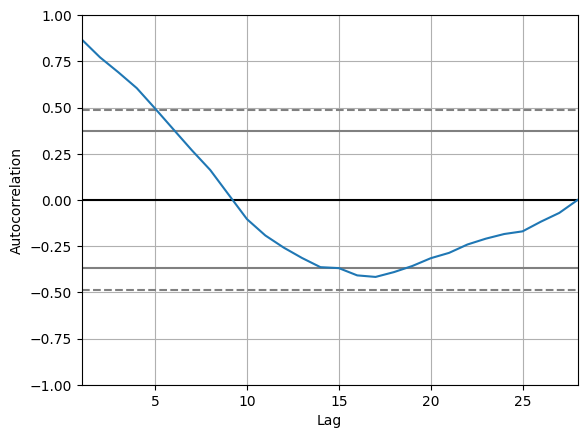

In [6]:
# Creating Autocorrelation plot - ACF
x = pd.plotting.autocorrelation_plot(data_filt['rev'])
x.plot()
plt.show()

The monotony of ACF is changed first time there is the p value. 

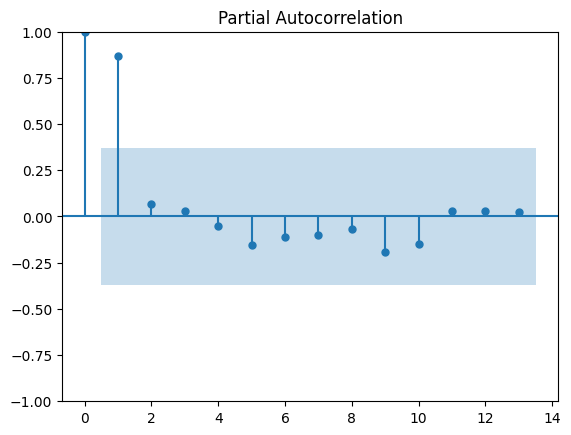

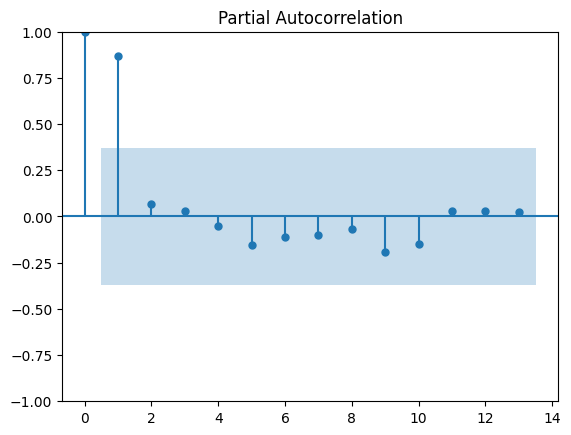

In [7]:
# Creating Partial Autocorrelation plot --> PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_filt['rev'], lags = 13)

Number of points, which are far away from the boundary is the q value.

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how a decide the q value. Hence the value of q is 2.

The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

I will find ARIMA hyperparameters (p, d, q) with gridsearch step-by-step

In [8]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    return error

In [9]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [10]:
# evaluate an ARIMA model for a given order (p,d,q) ---> You can tip p and estimate d, q based on previous plots
series = data_filt['rev']
# evaluate parameters
p_values = [2, 4, 6, 8, 10, 12]
d_values = [1]
q_values = [1, 2, 3]
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

37087.343670388625
ARIMA(2, 1, 1) MSE=37087.344
48253.321851858855
ARIMA(2, 1, 2) MSE=48253.322
52468.87727994185
ARIMA(2, 1, 3) MSE=52468.877
31221.743665322476
ARIMA(4, 1, 1) MSE=31221.744
42138.05480405174
ARIMA(4, 1, 2) MSE=42138.055
46208.67476051142
ARIMA(4, 1, 3) MSE=46208.675
52355.572953478804
ARIMA(6, 1, 1) MSE=52355.573
93761.98991143508
ARIMA(6, 1, 2) MSE=93761.990
56933.34942837896
ARIMA(6, 1, 3) MSE=56933.349
69788.14151749082
ARIMA(8, 1, 1) MSE=69788.142
111107.28055743682
ARIMA(8, 1, 2) MSE=111107.281
7193196.0898231985
ARIMA(8, 1, 3) MSE=7193196.090
5149111.442667032
ARIMA(10, 1, 3) MSE=5149111.443
Best ARIMA(4, 1, 1) MSE=31221.744


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model.

The parameter "s" is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect. Here is hardcoded, works well with 12.

In [11]:
# float datatype is needed to SARIMAX model
data_filt['rev'] = data_filt['rev'].astype(float)

In [12]:
# use the model parameters of SARIMA
p, d, q = 2, 1, 1
model=sm.tsa.statespace.SARIMAX(data_filt['rev'].values,
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91456D+00    |proj g|=  1.00616D-01

At iterate    5    f=  3.89119D+00    |proj g|=  2.25414D-02

At iterate   10    f=  3.88929D+00    |proj g|=  2.13809D-02

At iterate   15    f=  3.88177D+00    |proj g|=  1.12514D-02

At iterate   20    f=  3.87688D+00    |proj g|=  2.08711D-03


 This problem is unconstrained.



At iterate   25    f=  3.87656D+00    |proj g|=  6.11565D-04

At iterate   30    f=  3.87652D+00    |proj g|=  2.50888D-04

At iterate   35    f=  3.87650D+00    |proj g|=  1.21460D-03

At iterate   40    f=  3.87133D+00    |proj g|=  1.33436D-02

At iterate   45    f=  3.86415D+00    |proj g|=  6.68987D-03

At iterate   50    f=  3.86209D+00    |proj g|=  5.88489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   5.885D-03   3.862D+00
  F =   3.8620910155647552     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Result

In [13]:
period = 20
# use SARIMAX model
prediction_revenue = model.predict(len(data_filt), len(data_filt)+period)
# df from results
prediction = pd.DataFrame(
    prediction_revenue,
    index=[i+1 for i in range(len(prediction_revenue))],
    columns=['rev']
)

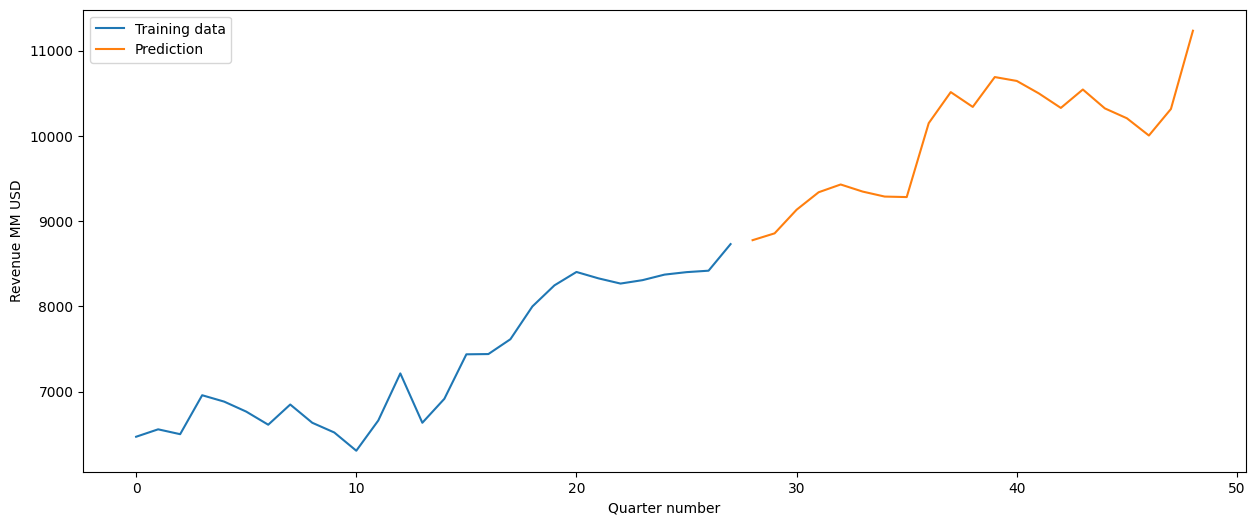

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(data_filt['rev'].index, data_filt['rev'].values, label='Training data')
ax1.plot(prediction.index+len(data_filt)-1, prediction['rev'], label='Prediction')

ax1.set_xlabel('Quarter number')
ax1.set_ylabel('Revenue MM USD')

plt.legend()
plt.show()

### 2.2. Calculate ratios

After the revenue prediction I calculate the expenses and use those to predict future CoS and EBITDA.

In [15]:
# create a function to calculate ratios
def calculate_margins(df):
    is_incomes = ['cost_sale', 'sale_gen_adm', 'r_d', 'other_charg']
    calc_margins = dict()
    # plot and calculate ratios
    for income in is_incomes:
        if income != 'inc_tax_exp':
            div = 'rev'
        else:
            div = 'inc_b_tax'

        fig, ax1 = plt.subplots(figsize=(15, 6))

        ax1.plot(df['date'], df[income]/df[div], label=income.replace('_', ' ').upper())
        ax1.axhline(y=(df[income]/df[div]).mean(), color='r', label='Average value')
        
        ax1.set_xlabel('Date')
        ax1.set_ylabel(income.replace('_', ' ').upper())
        
        plt.legend()
        plt.show()

        calc_margins[income+'_margin'] = (df[income]/df[div]).mean()

        print(str(income)+' is divided by the revenue.')
        print('Average value: '+str((df[income]/df[div]).mean()))

    return calc_margins

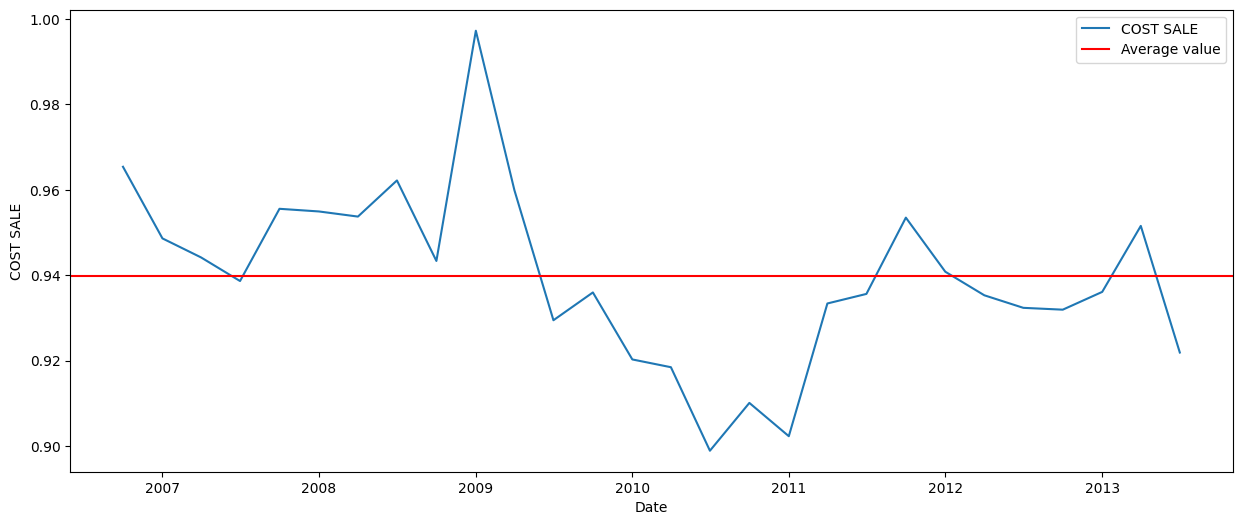

cost_sale is divided by the revenue.
Average value: 0.9396924761183086


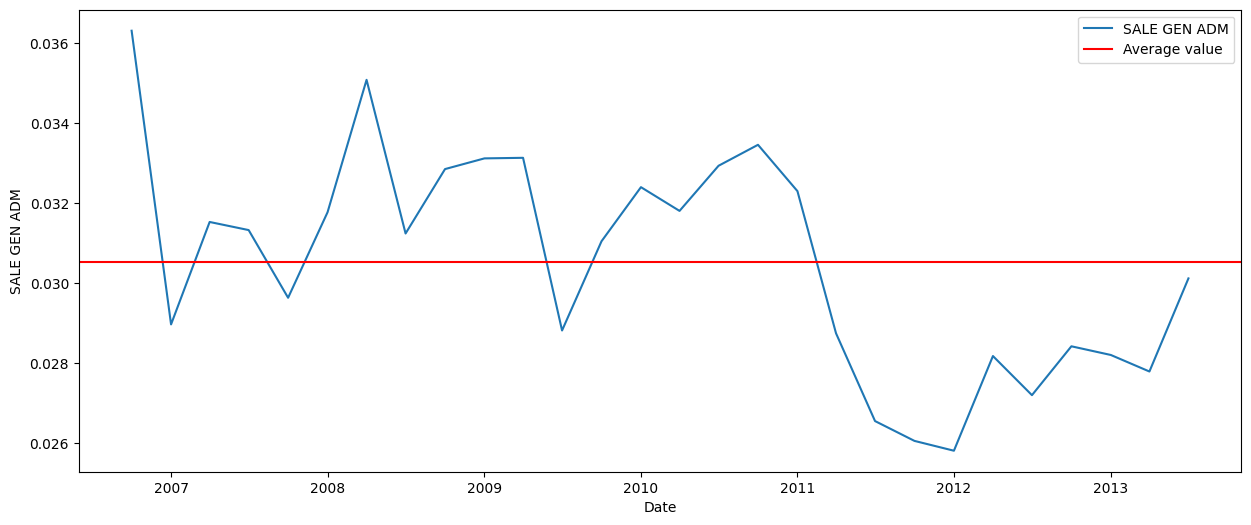

sale_gen_adm is divided by the revenue.
Average value: 0.030532870482121895


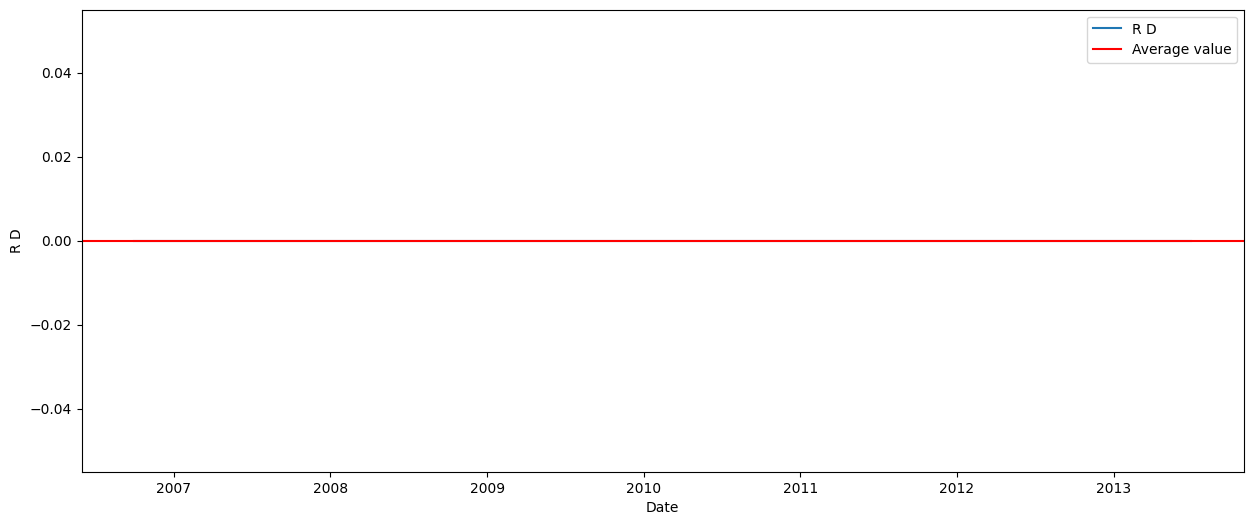

r_d is divided by the revenue.
Average value: 0.0


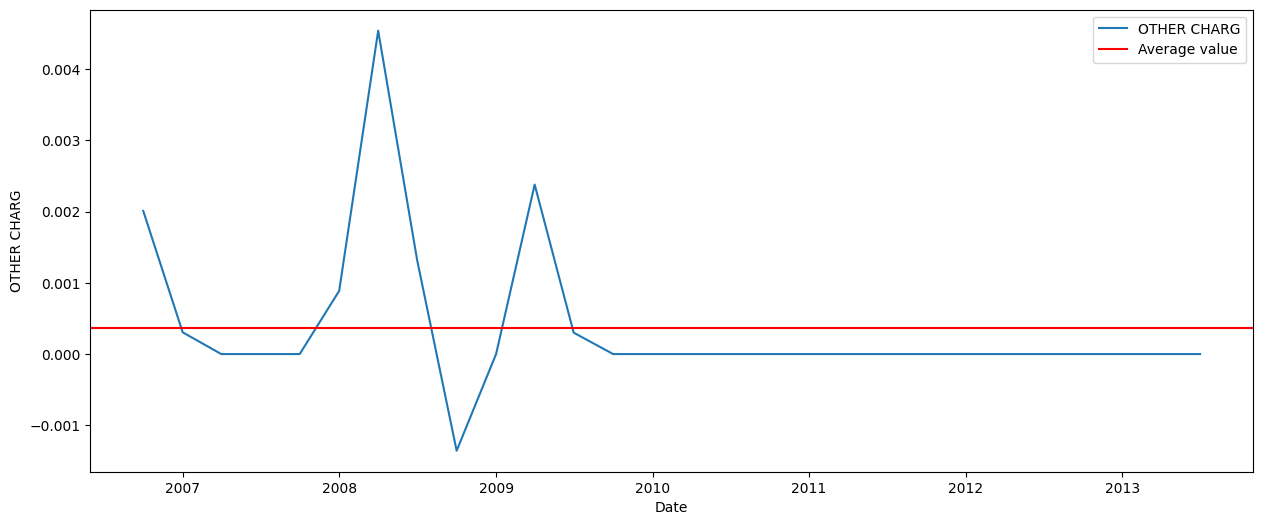

other_charg is divided by the revenue.
Average value: 0.0003705022626639577


In [16]:
base_case = calculate_margins(data_filt)

In [17]:
#prediction['ebit'] = prediction['ebitda'] - prediction['depr_amort']
for column in ['cost_sale', 'sale_gen_adm', 'r_d', 'other_charg']:
    prediction[column] = prediction['rev'] * base_case[column+'_margin']

prediction.tail()

,rev,cost_sale,sale_gen_adm,r_d,other_charg
17,10322.946679,9700.395325,315.189194,0.0,3.824675
18,10207.104003,9591.538834,311.652185,0.0,3.781755
19,10004.760729,9401.398382,305.474064,0.0,3.706786
20,10315.845634,9693.722528,314.972379,0.0,3.822044
21,11234.166655,10556.661881,343.011355,0.0,4.162284


## 2.3. Calculate Fixed Assets

It's time to calculate D&A costs.

I will predict the PPE, D&A and CapEx values together.

In [18]:
# fixed asset sliced dataframe
fixed_asset = data_filt.loc[:, ['ppe_net', 'depr_amort']]
# calculate PPE start & CAPEX
fixed_asset['ppe_net_start'] = [fixed_asset['ppe_net'].values[i-1] if i > 0 else np.nan for i in range(len(fixed_asset['ppe_net'].values))]
fixed_asset['capex'] = fixed_asset['ppe_net'] - fixed_asset['ppe_net_start'] + fixed_asset['depr_amort']

fixed_asset.head()

,ppe_net,depr_amort,ppe_net_start,capex
0,3945,134,NaN,NaN
1,3854,128,3945.0,37.0
2,3786,128,3854.0,60.0
3,3697,130,3786.0,41.0
4,3693,128,3697.0,124.0


In [19]:
def fixed_asset_ratios():
    fixed_asset_ratios = dict()
    # D&A ratio
    for column in ['depr_amort', 'capex']:
        ratio = fixed_asset[column]/fixed_asset['ppe_net_start']
        ratio.hist()
        plt.show()
        fixed_asset_ratios[column+'_ratio'] = ratio.mean()
        print('Average', column, 'value is', fixed_asset_ratios[column+'_ratio'])
    return fixed_asset_ratios

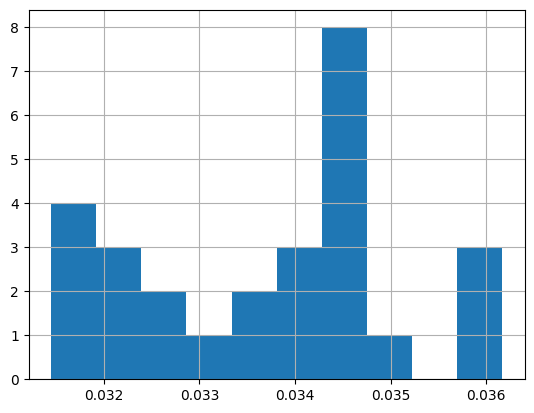

Average depr_amort value is 0.03367780968485032


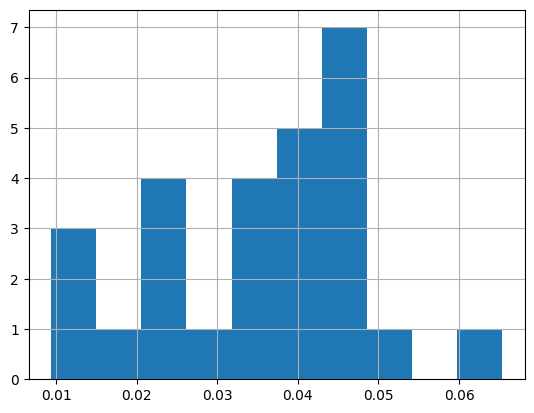

Average capex value is 0.034665901640475554


In [20]:
fxd_ass_ratios = fixed_asset_ratios()

In [21]:
def predict_fixed_assets(raw_df, prediction_df, fxd_ass_ratios):
    # get the last measured PPE as start in case of prediction
    ppe_start_pred = [raw_df['ppe_net'].iloc[-1]]
    depr_amort_pred = []
    capex_pred = []
    ppe_net = []
    # calculate prediction
    for index in range(len(prediction_df)):
        depr_amort_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['depr_amort_ratio'])
        capex_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['capex_ratio'])
        ppe_net.append(ppe_start_pred[-1] - depr_amort_pred[-1] + capex_pred[-1])
        # add the last PPE as starting to the PPE start
        ppe_start_pred.append(ppe_net[-1])
    
    prediction_df['depr_amort'] = depr_amort_pred
    prediction_df['capex'] = capex_pred
    prediction_df['ppe_net'] = ppe_net

    return prediction_df

In [22]:
prediction = predict_fixed_assets(data_filt, prediction, fxd_ass_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net
1,8776.985444,8247.667184,267.986560,0.0,3.251893,136.125707,140.119574,4045.993868
2,8857.130182,8322.978592,270.433609,0.0,3.281587,136.260211,140.258025,4049.991682
3,9134.385403,8583.513238,278.899006,0.0,3.384310,136.394849,140.396613,4053.993446
4,9339.190222,8775.966785,285.152285,0.0,3.460191,136.529620,140.535338,4057.999164
5,9430.280463,8861.563599,287.933532,0.0,3.493940,136.664524,140.674200,4062.008841


## 2.4. Calculate EBITDA, EBIT, NOPAT

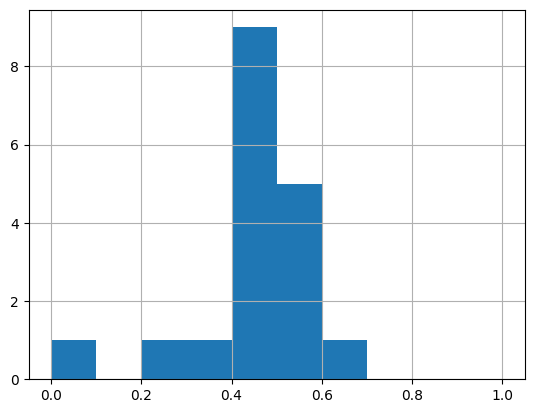

Effective tax rate is 0.42946599224870086


In [27]:
def calc_eff_tax_rate(df):
    if df['date'].iloc[-1] > pd.Timestamp('2017-01-01'):
        eff_tax_rate = 0.21
    else:
        eff_tax_rate = (data_filt['inc_tax_exp']/data_filt['ebit']).mean()
        # plot
        (data_filt['inc_tax_exp']/data_filt['ebit']).hist(range=[0, 1])
        plt.show()

    print('Effective tax rate is', eff_tax_rate)
    return eff_tax_rate

eff_tax_rate = calc_eff_tax_rate(data_filt)

In [30]:
def calculate_ebitda_ebit_nopat(prediction_df, eff_tax_rate):
    # if R&D or Other expenses missing itt will add nan, must to replace nan with 0
    prediction_df['r_d'] = prediction_df['r_d'].fillna(0.0)
    prediction_df['other_charg'] = prediction_df['other_charg'].fillna(0.0)
    prediction_df['ebitda'] = prediction_df['rev'] - prediction_df['cost_sale'] - prediction_df['sale_gen_adm'] - prediction_df['r_d'] - prediction_df['other_charg']
    prediction_df['ebit'] = prediction_df['ebitda'] - prediction_df['depr_amort']
    prediction_df['nopat'] = prediction_df['ebit'] - (prediction_df['ebit'] * eff_tax_rate)
    return prediction_df

In [32]:
prediction = calculate_ebitda_ebit_nopat(prediction, eff_tax_rate)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat
1,8776.985444,8247.667184,267.986560,0.0,3.251893,136.125707,140.119574,4045.993868,258.079807,121.954100,69.578961
2,8857.130182,8322.978592,270.433609,0.0,3.281587,136.260211,140.258025,4049.991682,260.436395,124.176183,70.846735
3,9134.385403,8583.513238,278.899006,0.0,3.384310,136.394849,140.396613,4053.993446,268.588849,132.194000,75.421173
4,9339.190222,8775.966785,285.152285,0.0,3.460191,136.529620,140.535338,4057.999164,274.610961,138.081341,78.780101
5,9430.280463,8861.563599,287.933532,0.0,3.493940,136.664524,140.674200,4062.008841,277.289392,140.624868,80.231270


## 2.5. Function to plot Prediction vs Historical data